<a href="https://colab.research.google.com/github/bytehub-ai/code-examples/blob/main/05_data_prep_carbon_intensity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ByteHub Feature Store: Data prep example

This notebook demo shows how to use feature transforms to organise and automate data preparation. As an example, we use [UK electricity carbon intensity](https://api.carbonintensity.org.uk/) data.


In [1]:
!pip install -q bytehub

In [2]:
import pandas as pd
import numpy as np
import os
import shutil
import bytehub as bh
import requests
print(f'ByteHub version {bh.__version__}')

ByteHub version 0.3.1


In [3]:
# Remove any previously created feature stores
try:
    os.remove('bytehub.db')
except FileNotFoundError:
    pass
try:
    shutil.rmtree('/tmp/featurestore/tutorial')
except FileNotFoundError:
    pass

Create a new featurestore - this will be stored in a local sqlite database named `bytehub.db`.

In [4]:
fs = bh.FeatureStore()

Next, create a namespace called `tutorial` to store some features in. Edit the url field to specify a local file storage location that you would like to use. Feature values will be saved within this folder using parquet format.

In [5]:
fs.create_namespace(
    'tutorial', url='/tmp/featurestore/tutorial', description='Data prep tutorial'
)

Fetch carbon intensity and fuel-mix data from [https://api.carbonintensity.org.uk/](https://api.carbonintensity.org.uk/). These datasets are provided as JSON dictionaries, which we will put in the feature store.

In [6]:
# API supports queries spanning up to 31 days
from_date = pd.Timestamp('2021-01-01')
to_date = pd.Timestamp('2021-01-31')

In [7]:
# Query for carbon intensity
response = requests.get(
  f'https://api.carbonintensity.org.uk/intensity/{from_date.strftime("%Y-%m-%dT%H:%MZ")}/{to_date.strftime("%Y-%m-%dT%H:%MZ")}',
)
response.raise_for_status()

df_carbon = pd.DataFrame(
    {
        'time': pd.to_datetime([row['from'] for row in response.json()['data']]).tz_localize(None),
        'value': [row['intensity'] for row in response.json()['data']]
    }
)
df_carbon.head()

,time,value
0,2020-12-31 23:30:00,"{'forecast': 190, 'actual': 184, 'index': 'mod..."
1,2021-01-01 00:00:00,"{'forecast': 181, 'actual': 187, 'index': 'mod..."
2,2021-01-01 00:30:00,"{'forecast': 178, 'actual': 182, 'index': 'mod..."
3,2021-01-01 01:00:00,"{'forecast': 175, 'actual': 178, 'index': 'mod..."
4,2021-01-01 01:30:00,"{'forecast': 174, 'actual': 171, 'index': 'mod..."


In [8]:
# Query for electricity generation fuel mix
response = requests.get(
  f'https://api.carbonintensity.org.uk/generation/{from_date.strftime("%Y-%m-%dT%H:%MZ")}/{to_date.strftime("%Y-%m-%dT%H:%MZ")}',
)
response.raise_for_status()
df_generation = pd.DataFrame(
    {
        'time': pd.to_datetime([row['from'] for row in response.json()['data']]).tz_localize(None),
        'value': [row['generationmix'] for row in response.json()['data']]
    }
)
df_generation.head()

,time,value
0,2020-12-31 23:30:00,"[{'fuel': 'biomass', 'perc': 10.8}, {'fuel': '..."
1,2021-01-01 00:00:00,"[{'fuel': 'biomass', 'perc': 10.9}, {'fuel': '..."
2,2021-01-01 00:30:00,"[{'fuel': 'biomass', 'perc': 10.8}, {'fuel': '..."
3,2021-01-01 01:00:00,"[{'fuel': 'biomass', 'perc': 11.1}, {'fuel': '..."
4,2021-01-01 01:30:00,"[{'fuel': 'biomass', 'perc': 11.3}, {'fuel': '..."


Save both of these raw datasets to the feature store. Setting `serialized=True` when creating the features allows more flexibility for the data format to change. For example, it will allow the JSON schema to vary over time without causing an error.

In [9]:
fs.create_feature('tutorial/rawdata.carbon', partition='year', serialized=True)
fs.save_dataframe(df_carbon, 'tutorial/rawdata.carbon')

In [10]:
fs.create_feature('tutorial/rawdata.generation', partition='year', serialized=True)
fs.save_dataframe(df_generation, 'tutorial/rawdata.generation')

Now we can use **feature transforms** to unpack data from the raw JSON format, and make time-series that could be used by ML-models. Start by extracting `forecast` and `actual` from the carbon intensity data.

In [11]:
# Extract carbon intensity forecast from dictionary
@fs.transform('tutorial/feature.carbon-forecast', from_features=['tutorial/rawdata.carbon'])
def unpack_carbon_forecast(df):
  return df['tutorial/rawdata.carbon'].apply(lambda x: x['forecast'])

# Extract carbon intensity actuals from dictionary
@fs.transform('tutorial/feature.carbon-actual', from_features=['tutorial/rawdata.carbon'])
def unpack_carbon_actual(df):
  return df['tutorial/rawdata.carbon'].apply(lambda x: x['actual'])

For generation, we calculate the percentage of low-carbon generation by addition together `biomass`, `nuclear`, `hydro`, `solar` and `wind`.

In [12]:
@fs.transform('tutorial/feature.low-carbon-fuels', from_features=['tutorial/rawdata.generation'])
def total_low_carbon(df):
  fuels = ['biomass', 'nuclear', 'hydro', 'solar', 'wind']
  def low_carbon(record):
    # Get the percentage for each low-carbon fuel
    low_carbon = [x['perc'] for x in record if x['fuel'] in fuels]
    return sum(low_carbon)
  return df['tutorial/rawdata.generation'].apply(low_carbon)

These data-prepartion steps are now saved within the feature store, and easily reusable for downstream data science tasks.

We can now call `fs.load_dataframe` to query and use our prepared features. Here we extract an hourly timeseries of carbon intensity and low-carbon fuel data, and plot on a scatter diagram.

In [13]:
df_prepared_data = fs.load_dataframe(['tutorial/feature.low-carbon-fuels', 'tutorial/feature.carbon-actual'], from_date=from_date, freq='1h')
df_prepared_data.head()

,tutorial/feature.low-carbon-fuels,tutorial/feature.carbon-actual
2021-01-01 00:00:00,48.5,187.0
2021-01-01 01:00:00,48.6,178.0
2021-01-01 02:00:00,51.3,167.0
2021-01-01 03:00:00,52.6,164.0
2021-01-01 04:00:00,54.9,155.0


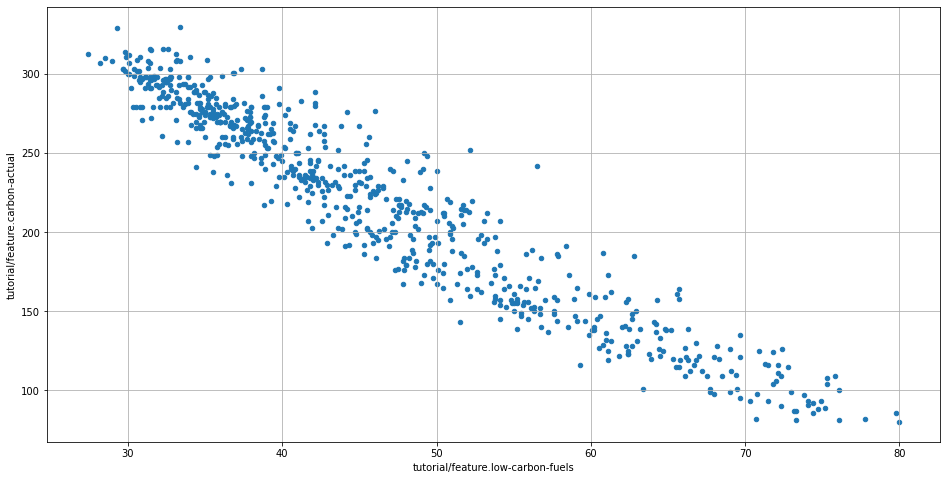

In [14]:
_ = df_prepared_data.plot.scatter(x='tutorial/feature.low-carbon-fuels', y='tutorial/feature.carbon-actual', figsize=(16, 8), grid=True)